In [39]:
import warnings

import botorch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from botorch.acquisition.analytic import UpperConfidenceBound

# from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.acquisition.logei import qLogNoisyExpectedImprovement
from botorch.exceptions.warnings import OptimizationWarning
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood
from botorch.optim import optimize_acqf
from matplotlib.figure import figaspect
from torch.quasirandom import SobolEngine
from tqdm.notebook import tqdm

plt.style.use("bmh")
plt.rc("figure", figsize=figaspect(3 / 4))

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=OptimizationWarning)

# torch.set_default_dtype(torch.float64)

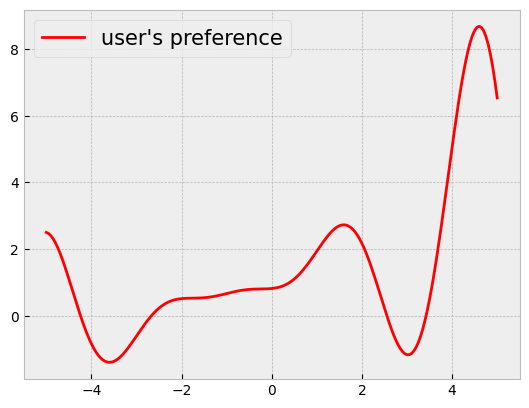

In [34]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1 + x / 3
    return y


lb = -5
ub = 5

bounds = torch.tensor([[lb], [ub]], dtype=torch.float)

xs = torch.linspace(lb, ub, 201)
ys = objective(xs)

plt.plot(xs, ys, label="user's preference", c="r")
plt.legend(fontsize=15)
# plt.axis("off")

plt.show()

In [35]:
def compare(y):
    assert y.numel() == 2

    if y.flatten()[0] > y.flatten()[1]:
        return torch.tensor([[0, 1]]).long()
    else:
        return torch.tensor([[1, 0]]).long()


def observe_and_append_data(x_next, f, x_train, comp_train, tol=1e-3):
    """
    x_next should be an experiment, i.e., a pair of locations
    """
    x_next = x_next.to(x_train)
    y_next = f(x_next)
    comp_next = compare(y_next)

    n = x_train.shape[-2]
    new_x_train = x_train.clone()
    new_comp_next = comp_next.clone() + n
    n_dups = 0

    ### first element
    dup_ind = torch.where(
        torch.all(torch.isclose(x_train, x_next[0], atol=tol), axis=1)
    )[0]
    if dup_ind.nelement() == 0:
        new_x_train = torch.cat([x_train, x_next[0].unsqueeze(-2)])
    else:
        # replace n with the duplicated index
        # decrement the other index
        new_comp_next = torch.where(new_comp_next == n, dup_ind, new_comp_next - 1)

        n_dups += 1

    ### second element
    dup_ind = torch.where(
        torch.all(torch.isclose(new_x_train, x_next[1], atol=tol), axis=1)
    )[0]
    if dup_ind.nelement() == 0:
        new_x_train = torch.cat([new_x_train, x_next[1].unsqueeze(-2)])
    else:
        # replace n + 1 with the duplicated index
        new_comp_next = torch.where(
            new_comp_next == n + 1 - n_dups, dup_ind, new_comp_next
        )

    new_comp_train = torch.cat([comp_train, new_comp_next])

    return new_x_train, new_comp_train

In [36]:
num_queries = 20
num_repeats = 10

In [43]:
strategy = "ucb"  # "random", "ei", or "ucb"
strategy = strategy.upper()

incumbents = torch.ones((num_repeats, num_queries)) * ys.min()

for trial in range(num_repeats):
    print("trial", trial)

    np.random.seed(trial)
    torch.manual_seed(trial)

    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(2, 1).double()
    train_y = objective(train_x)
    train_comp = compare(train_y)

    for i in range(num_queries):
        incumbent_ind = train_y.argmax()
        incumbents[trial, i] = train_y[incumbent_ind]

        model = PairwiseGP(train_x, train_comp)
        mll = PairwiseLaplaceMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        if strategy == "RANDOM":
            challenger = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 1)
        if strategy == "EI":
            policy = qLogNoisyExpectedImprovement(model, train_x)

            challenger, acq_val = optimize_acqf(
                policy,
                bounds=bounds,
                q=1,
                num_restarts=50,
                raw_samples=100,
            )
        if strategy == "UCB":
            policy = UpperConfidenceBound(model, beta=2)

            challenger, acq_val = optimize_acqf(
                policy,
                bounds=bounds,
                q=1,
                num_restarts=50,
                raw_samples=100,
            )

        # generate the pair to compare
        next_x = torch.vstack([train_x[incumbent_ind, :], challenger])

        train_x, train_comp = observe_and_append_data(
            next_x, objective, train_x, train_comp
        )

        train_y = objective(train_x)

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7


ModelFittingError: All attempts to fit the model have failed.

In [44]:
torch.save(incumbents, f"./forrester/{strategy}.pth")

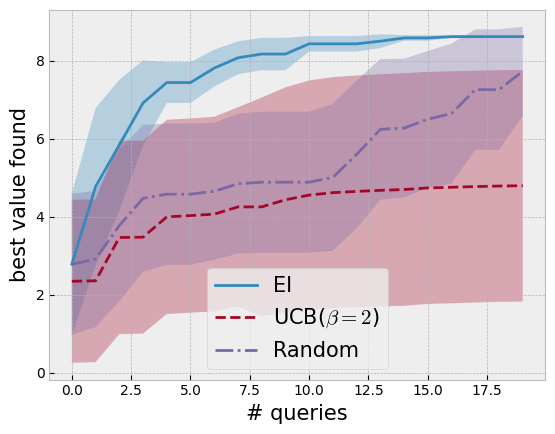

In [45]:
xs = torch.arange(num_queries)


def show_agg_progress(path, name, linestyle="solid"):
    def ci(y):
        return 2 * y.std(axis=0) / np.sqrt(num_repeats)

    incumbents = torch.load(path)
    avg_incumbent = incumbents.mean(axis=0)
    ci_incumbent = ci(incumbents)

    plt.plot(xs, avg_incumbent, linestyle, label=name)
    plt.fill_between(
        xs,
        avg_incumbent + ci_incumbent,
        avg_incumbent - ci_incumbent,
        alpha=0.3,
    )


show_agg_progress(
    "./forrester/EI.pth",
    "EI",
    "-",
)

show_agg_progress(
    "./forrester/UCB.pth",
    "UCB(" + r"$\beta = 2$" + ")",
    "--",
)

show_agg_progress(
    "./forrester/RANDOM.pth",
    "Random",
    "-.",
)

plt.xlabel("# queries", fontsize=15)
plt.ylabel("best value found", fontsize=15)
plt.legend(fontsize=15);